# HACKATHON RIMAC 2024

## LIBRERIAS 

In [ ]:
pip install pandas matplotlib seaborn numpy scikit-learn scipy pysentimiento language-tool-python nltk gensim xgboost ftfy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## IMPORTAR DATASETS

In [32]:
# En archivos con fechas hay que indicarle el tipo de encoding:
salesforces = pd.read_csv('datahack/base_casos_salesforce_rimac.csv', sep=',', encoding='latin1')
encuestados = pd.read_csv('datahack/encuestados_final.csv', sep=',', encoding='latin1')
info_financ = pd.read_csv('datahack/base_informacion_financiera.csv', sep=',', encoding='latin1')
productos = pd.read_csv('datahack/base_productos_rimac.csv', sep=',', encoding='latin1')
siniestros = pd.read_csv('datahack/base_siniestros_rimac.csv', sep=',', encoding='latin1')
m_variables = pd.read_csv('datahack/matriz_variables.csv', sep=',', encoding='latin1', low_memory=False)

## VARIABLE COMENTARIO - ENCUESTADOS

### PROCESAMIENTO VARIABLE 

In [ ]:
import pandas as pd
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import language_tool_python
import ftfy

# Descargar recursos necesarios para nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
# Inicializar la herramienta de corrección ortográfica para el idioma español
tool = language_tool_python.LanguageTool('es')

In [ ]:
ignore_words = ['RIMAC']

# Función para corregir el texto ortográficamente, ignorando palabras específicas
def correct_text(text):
    # Asegurarse de que el texto esté correctamente decodificado
    text = ftfy.fix_text(text)
    original_words = text.split()
    corrected_text = tool.correct(text)
    corrected_words = corrected_text.split()
    
    # Restaurar las palabras que deben ser ignoradas
    corrected_words_final = []
    for orig_word, corr_word in zip(original_words, corrected_words):
        if orig_word in ignore_words:
            corrected_words_final.append(orig_word)
        else:
            corrected_words_final.append(corr_word)
            
    return ' '.join(corrected_words_final)

# Aplicar la corrección ortográfica directamente a la columna 'Comentarios'
encuestados['Comentarios'] = encuestados['Comentarios'].apply(correct_text)

In [ ]:
# Función para normalizar el texto
def normalize_text(text):
    # Fija texto con ftfy
    text = ftfy.fix_text(text)
    # Eliminar entidades HTML
    text = re.sub(r'&[a-z]+;', ' ', text)
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar acentos y caracteres especiales
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    # Eliminar caracteres de puntuación que no son parte de palabras
    text = re.sub(r'[^\w\s]', ' ', text)
    # Eliminar múltiples espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Aplicar la normalización de texto solo en la columna 'Comentarios'
encuestados['Comentarios'] = encuestados['Comentarios'].apply(normalize_text)

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Tokenización
encuestados['tokens'] = encuestados['Comentarios'].apply(word_tokenize)

# Eliminar stopwords
stop_words = set(stopwords.words('spanish'))
encuestados['tokens'] = encuestados['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Lematización
lemmatizer = WordNetLemmatizer()
encuestados['tokens'] = encuestados['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Unir tokens en una sola cadena de texto
encuestados['cleaned_comentarios'] = encuestados['tokens'].apply(lambda x: ' '.join(x))

In [45]:
encuestados['NPS']

0        DETRACTOR
1        DETRACTOR
2        DETRACTOR
3        DETRACTOR
4        DETRACTOR
           ...    
24924     PROMOTOR
24925     PROMOTOR
24926     PROMOTOR
24927     PROMOTOR
24928     PROMOTOR
Name: NPS, Length: 24929, dtype: object

In [46]:
encuestados['tokens']

0        ['llame', 'rimac', 'emergencia', 'salud', 'nun...
1        ['rimac', 'mando', 'carta', 'notarial', 'traba...
2        ['llegue', 'taller', 'dijeron', 'habian', 'cho...
3        ['demoraron', '2', 'horas', 'cuarto', 'asistir...
4        ['quise', 'hacer', 'atiendan', 'seguro', 'habi...
                               ...                        
24924    ['medio', 'seguro', 'atiendo', 'clinica', 'int...
24925    ['brindan', 'servicios', 'necesito', 'familia'...
24926    ['buena', 'opcion', 'tener', 'tipo', 'seguro',...
24927    ['buenos', 'descuentos', 'organizados', 'rapid...
24928    ['gusta', 'cantidad', 'clinicas', 'involucrada...
Name: tokens, Length: 24929, dtype: object

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\626819551.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')


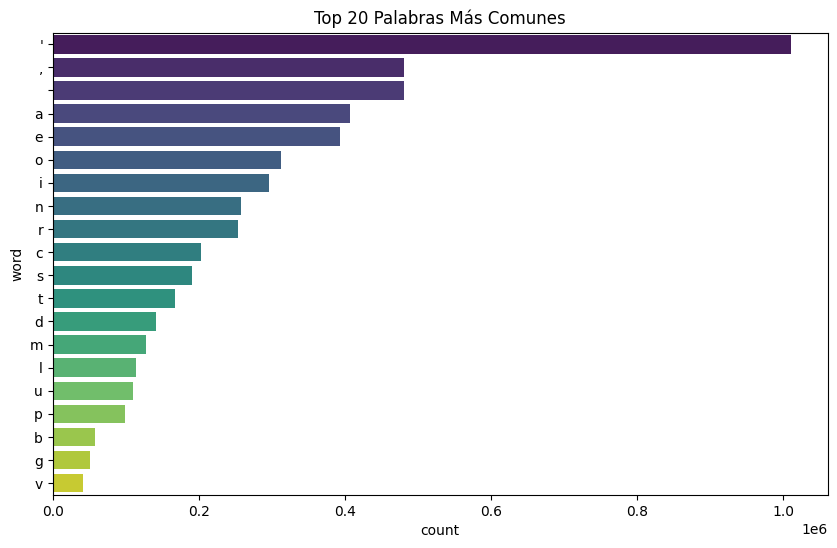

In [44]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Contar la frecuencia de las palabras
all_words = [word for tokens in encuestados['tokens'] for word in tokens]
word_freq = Counter(all_words)

# Obtener las 20 palabras más comunes
common_words = word_freq.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Visualizar las 20 palabras más comunes
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')
plt.title('Top 20 Palabras Más Comunes')
plt.show()


In [40]:
# Crear un diccionario de mapeo
mapeo_nps = {0: 'DETRACTOR', 1: 'PASIVO', 2: 'PROMOTOR'}

# Reemplazar los valores en la columna 'NPS' usando el diccionario de mapeo
encuestados['NPS'] = encuestados['NPS'].replace(mapeo_nps)

In [42]:
encuestados['tokens']

0        ['llame', 'rimac', 'emergencia', 'salud', 'nun...
1        ['rimac', 'mando', 'carta', 'notarial', 'traba...
2        ['llegue', 'taller', 'dijeron', 'habian', 'cho...
3        ['demoraron', '2', 'horas', 'cuarto', 'asistir...
4        ['quise', 'hacer', 'atiendan', 'seguro', 'habi...
                               ...                        
24924    ['medio', 'seguro', 'atiendo', 'clinica', 'int...
24925    ['brindan', 'servicios', 'necesito', 'familia'...
24926    ['buena', 'opcion', 'tener', 'tipo', 'seguro',...
24927    ['buenos', 'descuentos', 'organizados', 'rapid...
24928    ['gusta', 'cantidad', 'clinicas', 'involucrada...
Name: tokens, Length: 24929, dtype: object

In [50]:
category_data = encuestados[encuestados['NPS'] == category]

In [52]:
category_data['tokens']

0       ['llame', 'rimac', 'emergencia', 'salud', 'nun...
1       ['rimac', 'mando', 'carta', 'notarial', 'traba...
2       ['llegue', 'taller', 'dijeron', 'habian', 'cho...
3       ['demoraron', '2', 'horas', 'cuarto', 'asistir...
4       ['quise', 'hacer', 'atiendan', 'seguro', 'habi...
                              ...                        
2711    ['seguro', 'vida', 'futuro', 'esperando', 'tre...
2712    ['mejorar', 'atencion', 'cliente', 'brindar', ...
2713    ['exactamente', 'pague', 'seguro', 'padre', 'r...
2714    ['devolverian', 'completo', 'dinero', 'pago', ...
2715    ['creo', 'mejor', 'comunicacion', 'conmigo', '...
Name: tokens, Length: 2716, dtype: object

In [48]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lista de palabras a ignorar
ignore_words = {'seguro', 'rimac', 'rima'}

# Función para contar y graficar palabras comunes por categoría
def plot_common_words_by_nps(df, category, num_words=20):
    # Filtrar los datos por categoría de NPS
    category_data = df[df['NPS'] == category]
    
    if category_data.empty:
        print(f"No se encontraron datos para la categoría: {category}")
        return
    
    # Contar la frecuencia de las palabras, ignorando las que tengan menos de dos caracteres y las palabras específicas
    all_words = [word for tokens in category_data['tokens'] for word in tokens if len(word) > 1 and word not in ignore_words]
    word_freq = Counter(all_words)
    
    if not word_freq:
        print(f"No se encontraron palabras válidas para la categoría: {category}")
        return
    
    # Obtener las palabras más comunes
    common_words = word_freq.most_common(num_words)
    common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])
    
    # Visualizar las palabras más comunes
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')
    plt.title(f'Top {num_words} Palabras Más Comunes - {category}')
    plt.show()

# Graficar para cada categoría de NPS
categories = ['PROMOTOR', 'PASIVO', 'DETRACTOR']
for category in categories:
    plot_common_words_by_nps(encuestados, category)


No se encontraron palabras válidas para la categoría: PROMOTOR
No se encontraron palabras válidas para la categoría: PASIVO
No se encontraron palabras válidas para la categoría: DETRACTOR


In [53]:
# Mostrar una muestra de los datos
print(encuestados[['NPS', 'tokens']].head(10))


         NPS                                             tokens
0  DETRACTOR  ['llame', 'rimac', 'emergencia', 'salud', 'nun...
1  DETRACTOR  ['rimac', 'mando', 'carta', 'notarial', 'traba...
2  DETRACTOR  ['llegue', 'taller', 'dijeron', 'habian', 'cho...
3  DETRACTOR  ['demoraron', '2', 'horas', 'cuarto', 'asistir...
4  DETRACTOR  ['quise', 'hacer', 'atiendan', 'seguro', 'habi...
5  DETRACTOR  ['numero', 'placa', 'correcta', 'pedi', 'broke...
6  DETRACTOR  ['ultima', 'vez', 'atendieron', 'frente', 'acc...
7  DETRACTOR  ['accidente', 'hace', 'necesite', 'examenes', ...
8  DETRACTOR  ['mismo', 'atencion', 'lenta', 'sufrir', 'acci...
9  DETRACTOR  ['practicamente', 'timado', 'tranquilamente', ...


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1147876655.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['tokens'] = category_data['tokens'].apply(ensure_list)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1147876655.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')


Muestra de tokens antes del filtrado para la categoría PROMOTOR:
[list(['buena', 'atencion']) list(['eficaz'])
 list(['terminos', 'correctos', 'informacion', 'brindada', 'concreta', 'precisa'])]
Muestra de palabras después del filtrado para la categoría PROMOTOR:
['buena', 'atencion', 'eficaz', 'terminos', 'correctos', 'informacion', 'brindada', 'concreta', 'precisa', 'empresa', 'seria', 'companeros', 'trabajo', 'comentado', 'cosas', 'buena', 'empresa', 'provee', 'pais', 'serios']


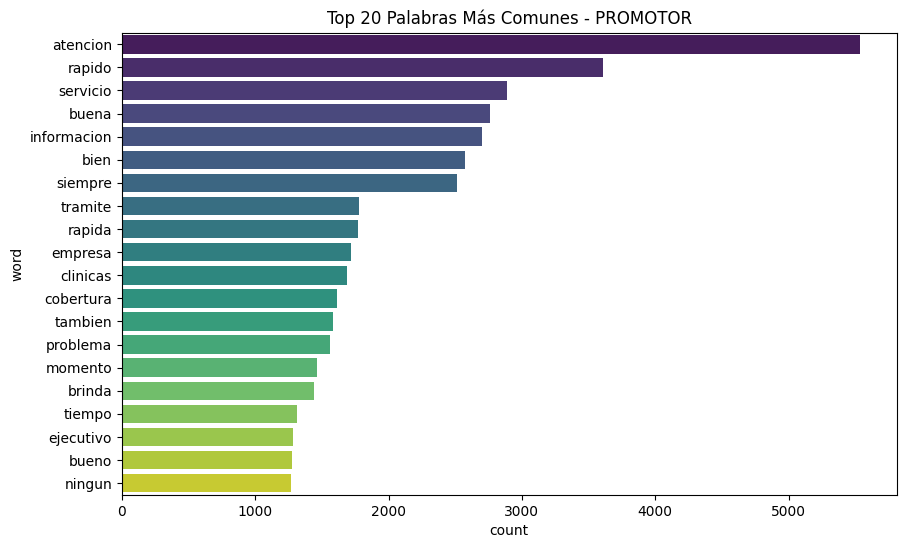

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1147876655.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['tokens'] = category_data['tokens'].apply(ensure_list)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1147876655.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')


Muestra de tokens antes del filtrado para la categoría PASIVO:
[list(['informar', 'mejor', 'seguros'])
 list(['llamar', 'preguntar', 'necesidades', 'asegurados'])
 list(['brinde', 'ma', 'seguridad', 'cajero', 'senales', 'alerta', 'manipulacion', 'antirrobos'])]
Muestra de palabras después del filtrado para la categoría PASIVO:
['informar', 'mejor', 'seguros', 'llamar', 'preguntar', 'necesidades', 'asegurados', 'brinde', 'seguridad', 'cajero', 'senales', 'alerta', 'manipulacion', 'antirrobos', 'contesten', 'rapido', 'sugiere', 'pregunta', 'telefono', 'sabria']


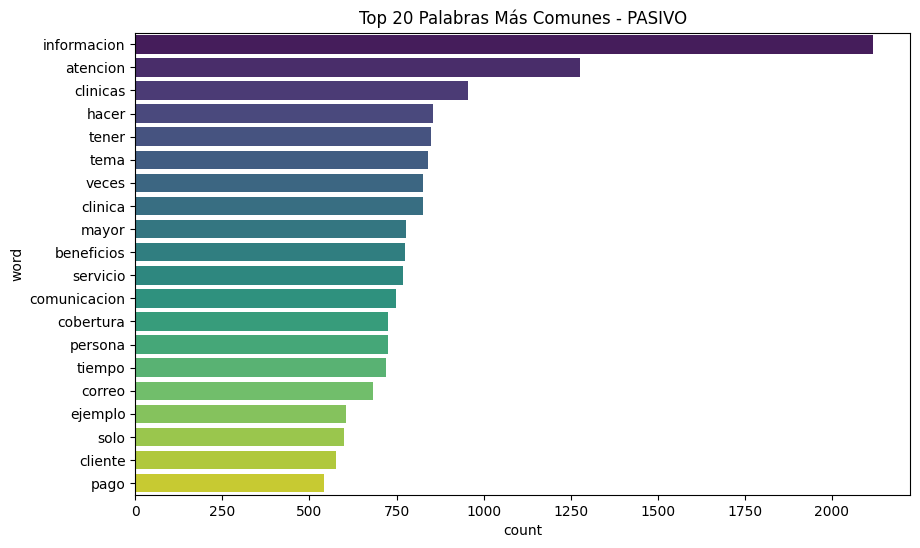

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1147876655.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_data['tokens'] = category_data['tokens'].apply(ensure_list)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1147876655.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')


Muestra de tokens antes del filtrado para la categoría DETRACTOR:
[list(['llame', 'rimac', 'emergencia', 'salud', 'nunca', 'contestaron', 'llame', 'banco', 'adquiri', 'dijeron', 'tenia', 'llamar', 'rimac', 'nunca', 'atendieron', 'gusto'])
 list(['rimac', 'mando', 'carta', 'notarial', 'trabajo', 'provocandome', 'problemas', 'brevete', 'suspendido', 'manda', 'trabajo', 'direccion', 'casa', 'autorice', 'manden', 'trabajo', 'habia', 'dado', 'consentimiento', 'motivo', 'grua', 'dieron', 'servicio', 'llego', 'grua', 'personal', 'vio', 'choque', 'dijo', 'va', 'malograr', 'plataforma', 'mando', 'mudar', 'hijo', 'reclamo', 'contesto', 'mala'])
 list(['llegue', 'taller', 'dijeron', 'habian', 'chocado', 'carro', 'explique', 'tena', 'dijeron', 'iba', 'venir', 'persona', 'tenia', 'verificar', 'carro', 'generar', 'costo', 'hicieron', 'inventario', 'carro', 'voy', 'recoger', 'carro', 'aire', 'acondicionado', 'funcionaba', 'habia', 'ido', 'gas', 'robaron', 'colonia', 'llaveros', 'tenia', 'remate', 'ch

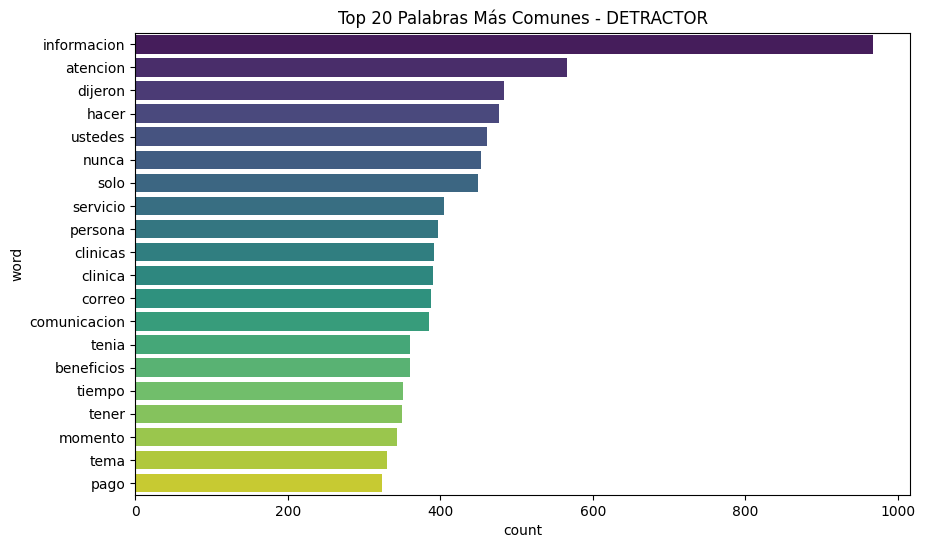

In [57]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lista de palabras a ignorar
ignore_words = {'seguro', 'rimac', 'rima'}

# Función para asegurar que los tokens sean listas
def ensure_list(tokens):
    if isinstance(tokens, str):
        # Si los tokens están en forma de cadena, convertirlos en lista
        return eval(tokens)
    return tokens

# Función para contar y graficar palabras comunes por categoría
def plot_common_words_by_nps(df, category, num_words=20):
    # Filtrar los datos por categoría de NPS
    category_data = df[df['NPS'] == category]
    
    if category_data.empty:
        print(f"No se encontraron datos para la categoría: {category}")
        return
    
    # Asegurar que los tokens sean listas
    category_data['tokens'] = category_data['tokens'].apply(ensure_list)
    
    # Mostrar una muestra de los tokens antes del filtrado
    print(f"Muestra de tokens antes del filtrado para la categoría {category}:")
    print(category_data['tokens'].head(3).values)
    
    # Contar la frecuencia de las palabras, ignorando las que tengan menos de cuatro caracteres y las palabras específicas
    all_words = [word for tokens in category_data['tokens'] for word in tokens if len(word) > 3 and word not in ignore_words]
    
    # Mostrar una muestra de las palabras después del filtrado
    print(f"Muestra de palabras después del filtrado para la categoría {category}:")
    print(all_words[:20])
    
    word_freq = Counter(all_words)
    
    if not word_freq:
        print(f"No se encontraron palabras válidas para la categoría: {category}")
        return
    
    # Obtener las palabras más comunes
    common_words = word_freq.most_common(num_words)
    common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])
    
    # Visualizar las palabras más comunes
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=common_words_df, palette='viridis')
    plt.title(f'Top {num_words} Palabras Más Comunes - {category}')
    plt.show()

# Graficar para cada categoría de NPS
categories = ['PROMOTOR', 'PASIVO', 'DETRACTOR']
for category in categories:
    plot_common_words_by_nps(encuestados, category)



In [58]:
import random

# Filtrar el DataFrame para obtener solo los registros que cumplan con los criterios
filtered_df = encuestados[(encuestados['NPS'] == 'DETRACTOR') & (encuestados['cleaned_comentarios'].str.contains('informacion'))]

# Seleccionar un caso aleatorio de los registros filtrados
if not filtered_df.empty:
    random_case = filtered_df.sample(n=1)
    print(random_case)
else:
    print("No se encontraron registros que cumplan con los criterios.")



                                  id_persona_token     periodo_encuesta  \
2618  ezeqHh1Upjs6FxwOoSxryBBkHvmi7hhRAiyVBSX9rfw=  2023-09-01 00:00:00   

     Ramo_encuesta       Seg_Ramo_encuesta Siniestralidad_encuesta  \
2618          VIDA  VIDA - VIDA INDIVIDUAL          No Siniestrado   

     Cod_Producto_encuesta                      Producto_encuesta  \
2618               AX-8786  VIDA FUTURO PROTEGIDO PLAN 35 AÃÂOS   

                                            Comentarios  Categoria        NPS  \
2618  brindar periodicamente mas informacion sobre e...          6  DETRACTOR   

      ...    Tema_2    Tema_3    Tema_4    Tema_5    Tema_6    Tema_7  \
2618  ...  0.001587  0.255341  0.001588  0.731958  0.001588  0.001588   

        Tema_8    Tema_9  comment_length  word_count  
2618  0.001588  0.001587             615          85  

[1 rows x 41 columns]


In [ ]:
encuestados["cleaned_comentarios"]

In [59]:
random_case["Comentarios"].tolist()

['brindar periodicamente mas informacion sobre en que consiste si no me equivoco es un seguro que vas pagando la verdad lo tome hace anos lo pago puntualmente pero ha pasado tanto tiempo que he olvidado cuales son los beneficios las prestaciones seria bueno que al menos una vez al ano no solo cobraran puntualmente que tambien pudieran brindar informacion que recordara en que consiste el seguro por correo electronico que envien un boletin como otras aseguradoras hacen de usted tiene este seguro por si acaso si sucede tal cosa lo activa de tal forma sino esta acumulando si usted no me llama para preguntarme que opino ni me acordaba que tenia este seguro y como es de debito automatico se que me lo cobran claro cada mes una cantidad pero habra pasado 8 anos no se en que consiste como cual es la cobertura cual es un beneficio adicional eso no informan solo lo cobran deberian informar como va']

### CREACION VARIABLE "sentimiento"

In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

In [ ]:
# Función para predecir el sentimiento de un comentario
def predecir_sentimiento(comentario):
    resultado = analyzer.predict(comentario)
    return resultado.output

# Aplicar la función de predicción a la columna 'comentario_final'
encuestados['sentimiento'] = encuestados['cleaned_comentarios'].apply(predecir_sentimiento)

In [ ]:
encuestados['sentimiento'].unique()

In [ ]:
encuestados['NPS'].unique()

In [ ]:
# Guardar el DataFrame ordenado
#encuestados.to_csv('encuestados_beto.csv', index=False)

In [ ]:
encuestados = pd.read_csv('encuestados_beto.csv',sep = ',', encoding = 'latin1')

In [ ]:
encuestados.info()

In [ ]:
# Codificar la variable 'sentimiento'
sentimiento_map = {'NEG': 0, 'NEU': 1, 'POS': 2}
encuestados['sentimiento'] = encuestados['sentimiento'].map(sentimiento_map)

In [ ]:
# Codificar la variable 'NPS'
nps_map = {'DETRACTOR': 0, 'PASIVO': 1, 'PROMOTOR': 2}
encuestados['NPS'] = encuestados['NPS'].map(nps_map)

In [ ]:
encuestados['NPS'].unique()

In [ ]:
encuestados['sentimiento'].unique()

In [ ]:
# Lista de palabras clave ampliada con nuevas categorías
keywords = {
    'seguro': ['seguro', 'poliza', 'cobertura', 'asegurado', 'protección'],
    'siniestro': ['siniestro', 'accidente', 'emergencia', 'incidente', 'daño', 'perdida'],
    'atencion_cliente': ['atencion', 'cliente', 'servicio', 'soporte', 'ayuda', 'contacto'],
    'tiempo': ['demora', 'espera', 'tiempo', 'rapido', 'lento', 'horas', 'dias'],
    'precio': ['precio', 'costo', 'tarifa', 'caro', 'barato'],
    'calidad': ['calidad', 'excelente', 'malo', 'bueno', 'deficiente'],
    'cobertura': ['cobertura', 'beneficio', 'incluye', 'excluye'],
    'reclamaciones': ['reclamacion', 'reclamo', 'queja', 'disputa'],
    'satisfaccion': ['satisfaccion', 'satisfecho', 'insatisfecho', 'contento', 'feliz', 'descontento'],
    'facilidad': ['facil', 'dificil', 'acceso', 'uso', 'simple', 'complicado'],
    'repeticion': ['nuevamente', 'otra vez', 'repetir', 'vuelvo', 'volver'],
    'comparacion': ['mejor', 'peor', 'comparado', 'competencia', 'otro'],
    'resolucion': ['resolucion', 'solucion', 'resuelto', 'arreglado'],
    'recomendacion': ['recomendar', 'recomendaria', 'sugerir', 'sugiero'],
    'insatisfaccion': ['horrible', 'terrible', 'pesimo', 'desastroso', 'inaceptable']
}

# Función para crear variables de palabras clave ampliada
def keyword_flags(tokens, keywords):
    flags = {}
    for key, words in keywords.items():
        flags[key] = any(word in tokens for word in words)
    return pd.Series(flags)

# Aplicar la función para crear nuevas variables
keyword_flags_df = encuestados['tokens'].apply(lambda x: keyword_flags(x, keywords))
encuestados = pd.concat([encuestados, keyword_flags_df], axis=1)
encuestados.head()



In [ ]:
from nltk.corpus import stopwords

# Descargar stopwords si no lo has hecho previamente
import nltk
nltk.download('stopwords')

# Obtener las palabras de parada en español
spanish_stop_words = stopwords.words('spanish')

# Aplicar la detección de stop words en el conjunto de entrenamiento
encuestados['Frecuencia_Stop_Words'] = encuestados['cleaned_comentarios'].apply(
    lambda x: sum(1 for palabra in x.split() if palabra.lower() in spanish_stop_words) / len(x.split()) if len(x.split()) > 0 else 0
)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Inicializar el vectorizador y el modelo LDA
vectorizer = CountVectorizer(max_features=1000, stop_words=spanish_stop_words)
lda = LatentDirichletAllocation(n_components=10, random_state=0)

# Ajustar y transformar los datos de entrenamiento
X_train = vectorizer.fit_transform(encuestados['cleaned_comentarios'])
lda_train_topics = lda.fit_transform(X_train)

# Agregar los temas al conjunto de entrenamiento
for i in range(10):
    encuestados[f'Tema_{i}'] = lda_train_topics[:, i]

In [ ]:
encuestados

In [ ]:
encuestados["Categoria"].unique()

In [ ]:
# Longitud de Comentarios en caracteres
encuestados['comment_length'] = encuestados['cleaned_comentarios'].apply(len)

# Número de palabras en cada comentario
encuestados['word_count'] = encuestados['cleaned_comentarios'].apply(lambda x: len(x.split()))

In [ ]:
encuestados.columns.tolist()

In [ ]:
encuestados.to_csv('encuestados_final.csv', index=False)

In [ ]:
encuestados.info()

In [ ]:
# Filtrar solo las columnas numéricas y excluir 'Categoria'
numeric_df = encuestados.select_dtypes(include=['float64', 'int64','bool']).drop(columns=['Categoria'])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Extraer las correlaciones con NPS_num
correlation_with_nps_num = correlation_matrix['NPS'].sort_values(ascending=False)

# Mostrar las correlaciones con NPS_num
print(correlation_with_nps_num)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Separar las características y la variable objetivo
X = numeric_df.drop(columns=['NPS'])
y = numeric_df['NPS']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo de Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Mostrar algunas predicciones
predicciones = pd.DataFrame({'Real': y_test, 'Predicho': y_pred})
print(predicciones.head(10))

In [ ]:
# Guardar la columna en un archivo CSV
encuestados.to_csv('encuestados_v2.csv', index=False)

In [ ]:
encuestados.head(250)


In [ ]:
salesforces.columns.tolist()

In [ ]:
encuestados.columns.tolist()

In [ ]:
info_financ.columns.tolist()

In [ ]:
productos.columns.tolist()

In [ ]:
siniestros.columns.tolist()

In [ ]:
siniestros['periodo']

In [ ]:
productos['periodo']

In [ ]:
info_financ['periodo']

In [ ]:
salesforces['fecha_apertura']

In [ ]:
encuestados['periodo_encuesta']

In [ ]:
m_variables['periodo_encuesta']

In [ ]:
m_variables.shape

In [ ]:
encuestados.shape

In [ ]:
salesforces.shape

In [ ]:
info_financ.shape

In [ ]:
productos.shape

In [ ]:
siniestros.shape

In [ ]:
salesforces.head()

## SALESFORCES

In [ ]:
salesforces.head()

In [ ]:
salesforces["origen"].unique()

In [ ]:
salesforces["solucion"].count()

In [ ]:
salesforces.shape

In [ ]:
salesforces["tipo_registro_caso"] = salesforces["tipo_registro_caso"].str.replace('ReclamaciÃ³n', 'Reclamacion', regex=False)

In [ ]:
import pandas as pd
# Filtrar los casos donde 'tipo_registro_caso' contiene "Reclamos" o "Reclamacion"
filtro_reclamos = salesforces[salesforces['tipo_registro_caso'].str.contains('Reclamos|Reclamacion', case=False, na=False)]

# Contar los casos por 'id_persona_token'
conteo_reclamos = filtro_reclamos.groupby('id_persona_token').size().reset_index(name='conteo_reclamos')

# Merge el conteo con el DataFrame original
salesforces = salesforces.merge(conteo_reclamos, on='id_persona_token', how='left')

# Reemplazar los valores NaN en la nueva columna con 0 (si no hay reclamos)
salesforces['conteo_reclamos'] = salesforces['conteo_reclamos'].fillna(0).astype(int)

# Mostrar los resultados
print(salesforces.head())


In [ ]:
import pandas as pd
# Contar la cantidad de 'numero_de_caso' por 'id_persona_token'
conteo_casos = salesforces.groupby('id_persona_token')['numero_de_caso'].count().reset_index(name='cantidad_casos')

# Merge el conteo con el DataFrame original
salesforces = salesforces.merge(conteo_casos, on='id_persona_token', how='left')

# Mostrar los resultadosb
salesforces.head()


In [ ]:
# Eliminar duplicados basado en 'id_persona_token'
salesforces_unicos = salesforces.drop_duplicates(subset=['id_persona_token'])

# Mostrar los resultados
salesforces_unicos.head()

In [ ]:
salesforces_unicos.shape

In [ ]:
import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')


# Asegurarse de que 'fecha_apertura' es de tipo datetime
salesforces_unicos['fecha_apertura'] = pd.to_datetime(salesforces_unicos['fecha_apertura'], errors='coerce')
salesforces_unicos['año_mes'] = salesforces_unicos['fecha_apertura'].dt.to_period('M')
# Crear una nueva columna 'solucion_contenido' que sea 1 si 'solucion' tiene contenido y 0 si está vacía
salesforces_unicos['solucion_contenido'] = salesforces_unicos['solucion'].notna().astype(int)
salesforces_unicos.head()

In [ ]:
# Guardar la columna en un archivo CSV
salesforces_unicos.to_csv('salesforces_v2.csv', index=False)

## SINIESTROS

In [ ]:
siniestros.head()

In [ ]:
siniestros["des_estado_siniestro"].unique()

In [ ]:
siniestros["riesgo"].unique()

In [ ]:
import pandas as pd
# Contar la cantidad de 'numero_de_caso' por 'id_persona_token'
cantidad_siniestros = siniestros.groupby('id_persona_token')['id_siniestro'].count().reset_index(name='cantidad_siniestros')

# Merge el conteo con el DataFrame original
siniestros = siniestros.merge(cantidad_siniestros, on='id_persona_token', how='left')

# Mostrar los resultados
siniestros.head()


In [ ]:
suma_monto = siniestros.groupby('id_persona_token')['mto_total_pagado_usd'].sum().reset_index(name='suma_mto_total_pagado_usd')

# Merge la suma con el DataFrame original
siniestros = siniestros.merge(suma_monto, on='id_persona_token', how='left')

# Mostrar los resultados
siniestros.head()

# CONSOLIDADA

In [3]:
# En archivos con fechas hay que indicarle el tipo de encoding:
consolidado = pd.read_csv('datahack/consolidado_v2.csv', sep=',', encoding='latin1')
consolidado.head()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\3106582093.py:2: DtypeWarning: Columns (149) have mixed types. Specify dtype option on import or set low_memory=False.
  consolidado = pd.read_csv('datahack/consolidado_v2.csv', sep=',', encoding='latin1')


,id_persona_token,periodo_encuesta,edad,segmento_growth,rcc_cluster_v2,ubigeo,ramo2,ingreso_estimado,flg_dig_APP_u1m,ratio_dig_APP_u3m,...,origen,fecha_apertura,tipo_registro_caso,solucion,estado,conteo_reclamos,cantidad_casos,anio_mes,aÃ±o_mes,solucion_contenido
0,jhRmuq4zerq22mY0DEgIN2krDJpgwf4RSHn5eS7ewfA=,2023-04,58,Otros,3.0,LIMA_CENTRO,VIDA,NaN,NaN,NaN,...,0,0,0,0,0,0.0,0.0,0,0,0.0
1,Rfem6bt2UvOz3xbN0RwKuwwElUSiY3h+yPgfIzgwvjA=,2023-04,40,Prosperous,4.0,LIMA_NORTE,VIDA,4250.5,NaN,NaN,...,TelÃÂ©fono,2023-02-20,Requerimiento u operaciones,<p><br></p><p>Se envÃÂ­an los datos al ÃÂ¡re...,Closed,0.0,3.0,2023-02,2023-02,1.0
2,yZsKImLDw9RS0RLuFm+TDCug81qONQlTbXI4B+7/KQc=,2023-11,37,Otros,3.0,LIMA_SUR,VIDA,1596.0,0.0,0.000000,...,TelÃÂ©fono,2023-10-18,Requerimiento u operaciones,<p>Sirva la presente para saludarlo(a) y a la ...,Closed,0.0,5.0,2023-10,2023-10,1.0
3,VL3rI3kUX89JaPUBumj2+ixJlcgLbCBSmiMmQP+LJpc=,2023-09,48,Otros,3.0,LIMA_NORTE,VIDA,1550.5,NaN,NaN,...,0,0,0,0,0,0.0,0.0,0,0,0.0
4,QRxQZ9clGT5pgE1MBXqzKnNrPuvcG0IdHbSGufsB5eI=,2023-09,42,Otros,3.0,LIMA_MODERNA,VIDA,2780.0,0.0,0.666667,...,Web,2023-07-25,RetenciÃÂ³n,0,No Retenido,0.0,2.0,2023-07,2023-07,0.0


In [61]:
consolidado["periodo_encuesta"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 24935 entries, 0 to 24934
Series name: periodo_encuesta
Non-Null Count  Dtype 
--------------  ----- 
24935 non-null  object
dtypes: object(1)
memory usage: 194.9+ KB


In [4]:
nulos = consolidado.isna().sum().reset_index().rename(columns={'index':'columna', 0:'nulos'}).sort_values(by = 'nulos', ascending=False)
nulos['percent_nulos'] = round((nulos['nulos'] / 24935) * 100,1)
#revisar nulos % a partir de 80%
show = nulos[nulos['percent_nulos'] >= 20]
show

,columna,nulos,percent_nulos
250,recencia_sin_salud_MATER_u6m,24797,99.4
52,recencia_sf_PLATFORM_u6m,24770,99.3
286,recencia_sin_gen_VIDA_u6m,24699,99.1
77,recencia_lead_VIDAFIN_u6m,24694,99.0
259,recencia_sin_salud_HOSP_u6m,24670,98.9
...,...,...,...
209,avg_indice_consumo_total_linea_tc_u3m,5576,22.4
210,avg_indice_consumo_total_linea_tc_u6m,5369,21.5
213,devstd_indice_consumo_total_linea_tc_u6m,5369,21.5
214,devstd_indice_consumo_total_linea_tc_u12m,5114,20.5


In [5]:
show["columna"].tolist()

['recencia_sin_salud_MATER_u6m',
 'recencia_sf_PLATFORM_u6m',
 'recencia_sin_gen_VIDA_u6m',
 'recencia_lead_VIDAFIN_u6m',
 'recencia_sin_salud_HOSP_u6m',
 'recencia_lead_VIDAGEN_u6m',
 'recencia_sf_DATA_u6m',
 'recencia_dig_TOBI_u6m',
 'recencia_sin_salud_EMER_u6m',
 'recencia_sin_salud_OTROS_u6m',
 'recencia_lead_PATRI_u6m',
 'vari_mto_saldo_cred_vehi_sbs_u12m',
 'vari_mto_saldo_cred_vehi_sbs_u6m',
 'recencia_lead_SALUD_u6m',
 'vari_mto_saldo_cred_vehi_sbs_u3m',
 'recencia_sin_gen_PATRI_u6m',
 'recencia_dig_WEBPUB_u6m',
 'recencia_sf_EMAIL_u6m',
 'recencia_lead_u6m',
 'recencia_sf_TLF_u6m',
 'vari_mto_saldo_cred_hipo_sbs_u12m',
 'vari_mto_saldo_cred_hipo_sbs_u6m',
 'vari_mto_saldo_cred_hipo_sbs_u3m',
 'recencia_sf_u6m',
 'recencia_sin_salud_AMBU_u6m',
 'recencia_sin_salud_u6m',
 'recencia_sin_gen_SALUD_u6m',
 'recencia_dig_WEBPRIV_u6m',
 'recencia_sin_gen_u6m',
 'recencia_dig_APP_u6m',
 'vari_mto_saldo_prest_pers_sbs_u12m',
 'vari_mto_saldo_prest_pers_sbs_u6m',
 'flg_lead_VIDAGEN_u1m'

In [6]:
# Filtrar solo las columnas numéricas y excluir 'Categoria'
numeric2_df = consolidado.select_dtypes(include=['float64', 'int64','bool']).drop(columns=['Categoria'])

# Calcular la matriz de correlación
correlation_matrix2 = numeric2_df.corr()

# Extraer las correlaciones con NPS_num
correlation_with_nps_num2 = correlation_matrix2['NPS'].sort_values(ascending=False)

# Mostrar las correlaciones con NPS_num
print(correlation_with_nps_num2)

NPS                          1.000000
sentimiento                  0.335476
Tema_0                       0.262458
Tema_2                       0.183775
recencia_sin_gen_VIDA_u6m    0.171018
                               ...   
Tema_8                      -0.171703
Tema_7                      -0.205439
comment_length              -0.302513
word_count                  -0.315655
Tema_5                      -0.442412
Name: NPS, Length: 337, dtype: float64


In [7]:
corr_cons = correlation_with_nps_num2.reset_index()
corr_cons.columns = ['Variable', 'Correlacion']

In [ ]:
corr_cons.to_csv('corr_cons.csv', index=False)

In [8]:

cons_copy = consolidado.copy()

In [9]:

# Calcular el porcentaje de nulos por columna
nulos_porcentaje = cons_copy.isnull().mean() * 100

# Mostrar el porcentaje de nulos
print(nulos_porcentaje)

# Eliminar columnas con más del 20% de nulos
df_limpio = cons_copy.drop(columns=nulos_porcentaje[nulos_porcentaje > 20].index)

# Seleccionar solo columnas numéricas para la imputación
columnas_numericas = df_limpio.select_dtypes(include=[np.number]).columns

# Imputar los nulos en las columnas numéricas restantes
df_limpio[columnas_numericas] = df_limpio[columnas_numericas].fillna(df_limpio[columnas_numericas].mean())

# Mostrar el DataFrame limpio
print(df_limpio)

id_persona_token      0.000000
periodo_encuesta      0.000000
edad                  0.000000
segmento_growth       0.324845
rcc_cluster_v2        0.324845
                        ...   
conteo_reclamos       0.000000
cantidad_casos        0.000000
anio_mes              0.000000
aÃ±o_mes              0.000000
solucion_contenido    0.000000
Length: 365, dtype: float64
                                   id_persona_token periodo_encuesta  edad  \
0      jhRmuq4zerq22mY0DEgIN2krDJpgwf4RSHn5eS7ewfA=          2023-04    58   
1      Rfem6bt2UvOz3xbN0RwKuwwElUSiY3h+yPgfIzgwvjA=          2023-04    40   
2      yZsKImLDw9RS0RLuFm+TDCug81qONQlTbXI4B+7/KQc=          2023-11    37   
3      VL3rI3kUX89JaPUBumj2+ixJlcgLbCBSmiMmQP+LJpc=          2023-09    48   
4      QRxQZ9clGT5pgE1MBXqzKnNrPuvcG0IdHbSGufsB5eI=          2023-09    42   
...                                             ...              ...   ...   
24930  yLQMo7ANLBMmZE13LdD1BwFipesBrqeaL2KniWjEQOg=          2022-06    68   
24931  

In [ ]:
df_limpio

In [ ]:
df_limpio.to_csv('df_limpio.csv', index=False)

In [10]:
cantidad_nulos = df_limpio.isnull().sum()
cantidad_nulos

id_persona_token       0
periodo_encuesta       0
edad                   0
segmento_growth       81
rcc_cluster_v2         0
                      ..
conteo_reclamos        0
cantidad_casos         0
anio_mes               0
aÃ±o_mes               0
solucion_contenido     0
Length: 174, dtype: int64

In [11]:
cantidad_nulos = cantidad_nulos.reset_index()
cantidad_nulos.columns = ['Variable', 'nulos']

In [ ]:
cantidad_nulos.to_csv('cantidad_nulos2.csv', index=False)

In [ ]:
df_limpio["cal_gral"].unique()

In [ ]:
df_limpio["lista_riesgos"].unique()

In [ ]:
df_limpio["lista_group1"].unique()

In [ ]:
df_limpio["lista_productos"].unique()

In [ ]:
df_limpio["nse"].unique()

In [ ]:
df_limpio["segmento_growth"].unique()

In [ ]:
df_limpio["des_lima_prov"].unique()

In [ ]:
df_limpio["ubigeo"].unique()

In [ ]:
df_limpio["Cod_Producto_encuesta"].unique()

In [ ]:
df_limpio["Producto_encuesta"].unique().size

In [12]:
import pandas as pd

# Supongamos que ya tienes tu DataFrame 'df_limpio' cargado
# Por ejemplo, cargándolo desde un archivo CSV:
# df_limpio = pd.read_csv('ruta_a_tu_archivo.csv')

# Definir las columnas a excluir
columnas_excluir = ['comentario_clean', 'comentario_corregido', 'comentario_final', 'solucion']

# Seleccionar solo las columnas categóricas, excluyendo las columnas especificadas
categorical_columns = df_limpio.select_dtypes(include=['object']).columns
categorical_columns = [col for col in categorical_columns if col not in columnas_excluir]

# Imputar valores nulos en variables categóricas con la moda, excluyendo las columnas especificadas
for column in categorical_columns:
    moda = df_limpio[column].mode()[0]
    df_limpio[column].fillna(moda, inplace=True)

# Mostrar el DataFrame limpio
print(df_limpio)



                                   id_persona_token periodo_encuesta  edad  \
0      jhRmuq4zerq22mY0DEgIN2krDJpgwf4RSHn5eS7ewfA=          2023-04    58   
1      Rfem6bt2UvOz3xbN0RwKuwwElUSiY3h+yPgfIzgwvjA=          2023-04    40   
2      yZsKImLDw9RS0RLuFm+TDCug81qONQlTbXI4B+7/KQc=          2023-11    37   
3      VL3rI3kUX89JaPUBumj2+ixJlcgLbCBSmiMmQP+LJpc=          2023-09    48   
4      QRxQZ9clGT5pgE1MBXqzKnNrPuvcG0IdHbSGufsB5eI=          2023-09    42   
...                                             ...              ...   ...   
24930  yLQMo7ANLBMmZE13LdD1BwFipesBrqeaL2KniWjEQOg=          2022-06    68   
24931  Bmod1+kyKBuwDf8roemvef7pFvMhNQADuyDTxwBG/0I=          2023-10    63   
24932  omE8jxslCdHpsxzM++7/chfUpOWXpDf65IVHa4CSnR4=          2022-08    51   
24933  1JYmK+8SF0zR2qXF+/F2tzbK4klp1Wv5J4658/3PdJM=          2023-06    61   
24934  fed9QetRFNiUHhZhyI6h2lP2EbIOVJ/i6fcOyurD88I=          2022-09    31   

       segmento_growth  rcc_cluster_v2        ubigeo          r

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\454303083.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio[column].fillna(moda, inplace=True)


In [13]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24935 entries, 0 to 24934
Columns: 174 entries, id_persona_token to solucion_contenido
dtypes: bool(15), float64(108), int64(24), object(27)
memory usage: 30.6+ MB


In [14]:
cantidad_nulos = df_limpio.isnull().sum()
cantidad_nulos

id_persona_token      0
periodo_encuesta      0
edad                  0
segmento_growth       0
rcc_cluster_v2        0
                     ..
conteo_reclamos       0
cantidad_casos        0
anio_mes              0
aÃ±o_mes              0
solucion_contenido    0
Length: 174, dtype: int64

In [16]:
df_limpio.to_csv('cons_limpio1.csv', index=False)

In [17]:
categorical_columns = df_limpio.select_dtypes(include=['object']).columns
numeric_columns = df_limpio.select_dtypes(include=['float64', 'int64','bool']).drop(columns=['Categoria']).columns

In [ ]:
categorical_columns.tolist()

In [ ]:
df_limpio[ 'tokens'].unique()

In [ ]:
numeric_columns.tolist()

In [18]:
df_limpio['des_estado_civil'] = df_limpio['des_estado_civil'].str.strip().str.lower()
estado_civil_map = {
    'soltero': 0,
    'casado': 1,
    'viudo': 2,
    'no determinado': 3,
    'separado': 4,
    'divorciado': 5
}

# Aplicar el mapeo a la columna 'des_estado_civil'
df_limpio['des_estado_civil_num'] = df_limpio['des_estado_civil'].map(estado_civil_map)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1912245538.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['des_estado_civil_num'] = df_limpio['des_estado_civil'].map(estado_civil_map)


In [19]:
segmento_growth_map = {
    'Otros': 0,
    'Prosperous': 1,
    'Change - Agents': 2
}

# Aplicar el mapeo a la columna 'segmento_growth'
df_limpio['segmento_growth_num'] = df_limpio['segmento_growth'].map(segmento_growth_map)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\2061723263.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['segmento_growth_num'] = df_limpio['segmento_growth'].map(segmento_growth_map)


In [20]:
ubigeo_map = {
    'LIMA_CENTRO': 0,
    'LIMA_NORTE': 1,
    'LIMA_SUR': 2,
    'LIMA_MODERNA': 3,
    'LIMA_ESTE': 4,
    'LIMA_TOP': 5,
    'CALLAO': 6,
    'PROV_SUR': 7,
    'PROV_NORTE': 8,
    'PROV_CENTRO': 9,
    'PROV_ORIENTE': 10,
    'BALNEARIOS_DEL_SUR': 11
}

# Aplicar el mapeo a la columna 'ubigeo'
df_limpio['ubigeo_num'] = df_limpio['ubigeo'].map(ubigeo_map)

# Mostrar el DataFrame con la nueva columna numérica
print(df_limpio[['ubigeo', 'ubigeo_num']])

             ubigeo  ubigeo_num
0       LIMA_CENTRO           0
1        LIMA_NORTE           1
2          LIMA_SUR           2
3        LIMA_NORTE           1
4      LIMA_MODERNA           3
...             ...         ...
24930      LIMA_TOP           5
24931    LIMA_NORTE           1
24932      LIMA_TOP           5
24933   LIMA_CENTRO           0
24934      LIMA_TOP           5

[24935 rows x 2 columns]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\3036909900.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['ubigeo_num'] = df_limpio['ubigeo'].map(ubigeo_map)


In [21]:
import pandas as pd

# Supongamos que ya tienes tu DataFrame 'df_limpio' cargado
# Por ejemplo, cargándolo desde un archivo CSV:
# df_limpio = pd.read_csv('ruta_a_tu_archivo.csv')

# Crear el mapeo manual de categorías a valores numéricos
ramo2_map = {
    'VIDA': 0,
    'PATRIMONIALES': 1,
    'SALUD': 2
}

# Aplicar el mapeo a la columna 'ramo2'
df_limpio['ramo2_num'] = df_limpio['ramo2'].map(ramo2_map)

# Mostrar el DataFrame con la nueva columna numérica
print(df_limpio[['ramo2', 'ramo2_num']])


               ramo2  ramo2_num
0               VIDA          0
1               VIDA          0
2               VIDA          0
3               VIDA          0
4               VIDA          0
...              ...        ...
24930          SALUD          2
24931           VIDA          0
24932  PATRIMONIALES          1
24933          SALUD          2
24934          SALUD          2

[24935 rows x 2 columns]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1048108952.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['ramo2_num'] = df_limpio['ramo2'].map(ramo2_map)


In [22]:
nse_map = {
    'A1': 0,
    'A2': 1,
    'B1': 2,
    'B2': 3,
    'C1': 4,
    'C2': 5,
    'D': 6,
    'E': 7
}

# Aplicar el mapeo a la columna 'nse'
df_limpio['nse_num'] = df_limpio['nse'].map(nse_map)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\378178521.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['nse_num'] = df_limpio['nse'].map(nse_map)


In [23]:
des_lima_prov_map = {
    'LIMA-CALLAO': 0,
    'PROVINCIA': 1,
    'NO DETERMINADO': 2
}

# Aplicar el mapeo a la columna 'des_lima_prov'
df_limpio['des_lima_prov_num'] = df_limpio['des_lima_prov'].map(des_lima_prov_map)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\634794772.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['des_lima_prov_num'] = df_limpio['des_lima_prov'].map(des_lima_prov_map)


In [24]:
cal_gral_map = {
    'NORMAL': 0,
    'CON PROBLEMAS POTENCIALES': 1,
    'DEFICIENTE': 2,
    'DUDOSO': 3,
    'PERDIDA': 4
}

# Aplicar el mapeo a la columna 'cal_gral'
df_limpio['cal_gral_num'] = df_limpio['cal_gral'].map(cal_gral_map)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\3810915240.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_limpio['cal_gral_num'] = df_limpio['cal_gral'].map(cal_gral_map)


In [25]:
siniestro_map = {
    'Siniestrado': 1,
    'No Siniestado': 0
}

# Aplicar el mapeo a la columna 'Siniestralidad_encuesta'
df_limpio['Siniestralidad_encuesta'] = df_limpio['Siniestralidad_encuesta'].map(siniestro_map)

In [26]:
df_limpio['Siniestralidad_encuesta'].fillna(0, inplace=True)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_2920\1364563167.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_limpio['Siniestralidad_encuesta'].fillna(0, inplace=True)


In [27]:
df_limpio['tokens']

0        ['excelente', 'ejecutivo', 'brinda', 'informac...
1                         ['atencion', 'clara', 'precisa']
2        ['agradece', 'apoyo', 'asesores', 'caso', 'eje...
3        ['empresa', 'confiable', 'nunca', 'pasado', 'm...
4        ['buena', 'atencion', 'facil', 'entender', 'co...
                               ...                        
24930    ['eficiente', 'hacen', 'ningun', 'tipo', 'prob...
24931    ['empresa', 'seria', 'ninguna', 'queja', 'siem...
24932    ['rapido', 'eficiente', 'servicio', 'atencion'...
24933    ['seguimiento', 'solo', 'encuesta', 'comunicar...
24934    ['mejores', 'precios', 'descuenta', 'eps', 'me...
Name: tokens, Length: 24935, dtype: object

In [62]:
df_limpio

,id_persona_token,periodo_encuesta,edad,segmento_growth,rcc_cluster_v2,ubigeo,ramo2,ingreso_estimado,nse,flg_fallecido,...,anio_mes,aÃ±o_mes,solucion_contenido,des_estado_civil_num,segmento_growth_num,ubigeo_num,ramo2_num,nse_num,des_lima_prov_num,cal_gral_num
0,jhRmuq4zerq22mY0DEgIN2krDJpgwf4RSHn5eS7ewfA=,2023-04,58,Otros,3.0,LIMA_CENTRO,VIDA,6493.814843,B1,0,...,0,0,0.0,0,0,0,0,2,0,0
1,Rfem6bt2UvOz3xbN0RwKuwwElUSiY3h+yPgfIzgwvjA=,2023-04,40,Prosperous,4.0,LIMA_NORTE,VIDA,4250.500000,B1,0,...,2023-02,2023-02,1.0,0,1,1,0,2,0,0
2,yZsKImLDw9RS0RLuFm+TDCug81qONQlTbXI4B+7/KQc=,2023-11,37,Otros,3.0,LIMA_SUR,VIDA,1596.000000,B2,0,...,2023-10,2023-10,1.0,0,0,2,0,3,0,4
3,VL3rI3kUX89JaPUBumj2+ixJlcgLbCBSmiMmQP+LJpc=,2023-09,48,Otros,3.0,LIMA_NORTE,VIDA,1550.500000,B2,0,...,0,0,0.0,1,0,1,0,3,0,0
4,QRxQZ9clGT5pgE1MBXqzKnNrPuvcG0IdHbSGufsB5eI=,2023-09,42,Otros,3.0,LIMA_MODERNA,VIDA,2780.000000,B1,0,...,2023-07,2023-07,0.0,0,0,3,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24930,yLQMo7ANLBMmZE13LdD1BwFipesBrqeaL2KniWjEQOg=,2022-06,68,Otros,2.0,LIMA_TOP,SALUD,1881.000000,C1,0,...,2023-02,2023-02,0.0,0,0,5,2,4,0,0
24931,Bmod1+kyKBuwDf8roemvef7pFvMhNQADuyDTxwBG/0I=,2023-10,63,Prosperous,2.0,LIMA_NORTE,VIDA,7250.500000,B1,0,...,0,0,0.0,0,1,1,0,2,0,0
24932,omE8jxslCdHpsxzM++7/chfUpOWXpDf65IVHa4CSnR4=,2022-08,51,Prosperous,2.0,LIMA_TOP,PATRIMONIALES,3290.000000,A2,0,...,2023-04,2023-04,0.0,1,1,5,1,1,0,0
24933,1JYmK+8SF0zR2qXF+/F2tzbK4klp1Wv5J4658/3PdJM=,2023-06,61,Prosperous,2.0,LIMA_CENTRO,SALUD,6750.500000,B1,0,...,2023-07,2023-07,1.0,0,1,0,2,2,0,0


In [63]:
import pandas as pd

# Asegurarse de que la columna 'periodo_encuesta' está en formato de fecha
df_limpio['periodo_encuesta'] = pd.to_datetime(df_limpio['periodo_encuesta'], format='%Y-%m')

# Filtrar los datos para data_train y data_test
data_train = df_limpio[(df_limpio['periodo_encuesta'] >= '2022-01') & (df_limpio['periodo_encuesta'] <= '2023-09')]
data_test = df_limpio[(df_limpio['periodo_encuesta'] >= '2023-10') & (df_limpio['periodo_encuesta'] <= '2023-12')]

# Mostrar información de los conjuntos de datos resultantes
print("Data Train:")
print(data_train.info())

print("\nData Test:")
print(data_test.info())


Data Train:
<class 'pandas.core.frame.DataFrame'>
Index: 20319 entries, 0 to 24934
Columns: 181 entries, id_persona_token to cal_gral_num
dtypes: bool(15), datetime64[ns](1), float64(109), int64(31), object(25)
memory usage: 26.2+ MB
None

Data Test:
<class 'pandas.core.frame.DataFrame'>
Index: 4616 entries, 2 to 24931
Columns: 181 entries, id_persona_token to cal_gral_num
dtypes: bool(15), datetime64[ns](1), float64(109), int64(31), object(25)
memory usage: 5.9+ MB
None


# MODELOS

In [64]:
data_train[numeric_columns]

,edad,rcc_cluster_v2,ingreso_estimado,flg_fallecido,flg_empleado_rimac,flg_empleado_bbva,flg_empleado_breca,num_antiguedad_cliente,num_certificados_vig,num_productos,...,Tema_6,Tema_7,Tema_8,Tema_9,comment_length,word_count,numero_de_caso,conteo_reclamos,cantidad_casos,solucion_contenido
0,58,3.0,6493.814843,0,0,0,0,0,0,0,...,0.014286,0.014286,0.014286,0.014286,56,6,0.0,0.0,0.0,0.0
1,40,4.0,4250.500000,0,0,0,0,0,0,0,...,0.025001,0.025000,0.025000,0.025004,22,3,19454419.0,0.0,3.0,1.0
3,48,3.0,1550.500000,0,0,0,0,0,0,0,...,0.009092,0.009092,0.009092,0.009092,75,11,0.0,0.0,0.0,0.0
4,42,3.0,2780.000000,0,0,0,0,1,1,1,...,0.011111,0.011111,0.011111,0.011112,70,8,20419253.0,0.0,2.0,0.0
6,54,3.0,12500.500000,0,0,0,0,0,0,0,...,0.007144,0.133685,0.007144,0.007143,139,19,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24929,68,2.0,3825.000000,0,0,0,0,16,1,1,...,0.699998,0.033333,0.033333,0.033335,37,4,20005857.0,0.0,6.0,1.0
24930,68,2.0,1881.000000,0,0,0,0,1,2,1,...,0.009092,0.009092,0.009091,0.252900,82,11,19428792.0,0.0,5.0,0.0
24932,51,2.0,3290.000000,0,0,0,0,5,9,3,...,0.005002,0.005002,0.240080,0.005001,181,24,19715413.0,0.0,2.0,0.0
24933,61,2.0,6750.500000,0,0,0,0,23,1,1,...,0.003335,0.003334,0.003334,0.003334,219,31,20309489.0,0.0,2.0,1.0


In [66]:
# Separar las características y la variable objetivo
from sklearn.model_selection import train_test_split
X = data_train[numeric_columns].drop(columns=['NPS'])
y = data_train['NPS']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



# Entrenar un modelo de Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Mostrar algunas predicciones
predicciones = pd.DataFrame({'Real': y_test, 'Predicho': y_pred})
print(predicciones.head(10))

Accuracy: 0.7635334645669292
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.10      0.16       452
           1       0.61      0.60      0.60      1013
           2       0.82      0.95      0.88      2599

    accuracy                           0.76      4064
   macro avg       0.66      0.55      0.55      4064
weighted avg       0.74      0.76      0.73      4064

       Real  Predicho
10649     2         2
23639     0         1
2397      2         2
12528     2         2
18051     2         2
23418     2         2
21510     2         2
13462     1         2
10546     2         2
1625      1         2


In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import log_loss
import pandas as pd

# Definir los clasificadores base con hiperparámetros ajustados
clf_log2 = LogisticRegression(C=1, class_weight=None, solver='newton-cg', random_state=1)

clf_xgb = XGBClassifier(
    objective='multi:softprob',
    scale_pos_weight=1,
    max_depth=5,  # Reducir la profundidad máxima de los árboles
    gamma=0.3,
    colsample_bytree=0.8,  # Submuestreo de columnas
    subsample=0.8,  # Submuestreo de filas
    alpha=10,  # Regularización L1
    reg_lambda=10,  # Regularización L2
    learning_rate=0.01,  # Reducir la tasa de aprendizaje
    n_estimators=500,  # Aumentar el número de árboles
    seed=27
)

clf_nb2 = GaussianNB()

clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Reducir la profundidad máxima de los árboles
    min_samples_split=10,  # Aumentar el número mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=4,  # Aumentar el número mínimo de muestras en una hoja
    random_state=1
)

clf_gbm = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.01,  # Reducir la tasa de aprendizaje
    max_depth=5,  # Reducir la profundidad máxima de los árboles
    min_samples_split=10,  # Aumentar el número mínimo de muestras requeridas para dividir un nodo
    min_samples_leaf=4,  # Aumentar el número mínimo de muestras en una hoja
    random_state=1
)

# Definir el VotingClassifier
clf_voting = VotingClassifier(
    estimators=[
        ('lr', clf_log2),
        ('xgb', clf_xgb),
        ('nb', clf_nb2),
        ('rf', clf_rf),
        ('gbm', clf_gbm)
    ],
    voting='soft'
)

# Entrenar el VotingClassifier en el conjunto de entrenamiento
clf_voting.fit(X_train, y_train)

# Calcular el log loss en el conjunto de entrenamiento para referencia
y_pred_proba_voting_train = clf_voting.predict_proba(X_train)
log_loss_voting_train = log_loss(y_train, y_pred_proba_voting_train)
print(f'Voting Classifier Training Log Loss: {log_loss_voting_train}')

# Predecir en el conjunto de prueba
y_pred_proba_voting_test = clf_voting.predict_proba(X_test)

# Calcular el log loss en el conjunto de prueba
log_loss_voting_test = log_loss(y_train, clf_voting.predict_proba(X_train))
print(f'Voting Classifier Test Log Loss: {log_loss_voting_test}')

# EMBUDO RANDOM FOREST

In [69]:
#Crección de las matriz X de variables predictoras y el Y el target
X = data_train[numeric_columns].drop(columns=['NPS'])
y = data_train['NPS']
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=1416,stratify=y)

In [70]:
### Entreno un modelo de Random Forest con 200 arboles y una semilla aleatoria 123
rf_clf = RandomForestClassifier(n_estimators=200,random_state =123)   ## forma del modelo

# Entreno el modelo con el .fit
rf_clf.fit(X_train.values,y_train.values.ravel())

RandomForestClassifier(n_estimators=200, random_state=123)

In [71]:
y_pred = rf_clf.predict(X_test.values)


In [72]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.7521325459317585
              precision    recall  f1-score   support

           0       0.52      0.09      0.16       680
           1       0.61      0.57      0.59      1557
           2       0.80      0.94      0.87      3859

    accuracy                           0.75      6096
   macro avg       0.65      0.53      0.54      6096
weighted avg       0.72      0.75      0.72      6096



In [73]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.5383318352891284

In [74]:
importances = rf_clf.feature_importances_
importances

array([1.23084428e-02, 2.56320410e-03, 1.23882628e-02, 1.62136857e-06,
       1.40349151e-04, 1.20135798e-04, 2.48599952e-04, 8.41997982e-03,
       3.86115466e-03, 2.59552815e-03, 1.63269572e-03, 2.16816233e-03,
       1.06898472e-02, 1.16019842e-03, 1.28748555e-03, 1.78376169e-04,
       3.04004525e-04, 1.50593000e-03, 2.10538521e-03, 2.05841101e-03,
       3.26531494e-03, 1.00830737e-02, 2.78417909e-03, 2.90569432e-03,
       6.12077792e-03, 2.41534204e-03, 2.87704307e-03, 7.24115534e-03,
       2.14910452e-03, 3.61674675e-03, 7.09779463e-03, 7.31531549e-03,
       3.73497069e-03, 4.59706928e-03, 4.18941645e-03, 1.09111327e-02,
       3.04123359e-03, 3.91378389e-03, 5.23478648e-03, 1.23100373e-03,
       2.90118740e-03, 4.41389879e-03, 2.57251425e-03, 3.67532038e-03,
       4.50140048e-03, 4.16978494e-03, 5.60461937e-03, 6.62324080e-03,
       1.71939101e-03, 3.42567457e-03, 5.55304055e-03, 3.39082881e-03,
       4.42464704e-03, 5.35582995e-03, 1.04672424e-02, 1.06599759e-02,
      

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
    # Add more parameters here
}

# Initialize the grid search model
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train.values, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [100, 200, 300]})

In [76]:
best_model = grid_search.best_estimator_


In [77]:
y_pred2 = best_model.predict(X_test)

C:\Users\USUARIO\miniconda3\envs\mi_entorno\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [78]:
f1 = f1_score(y_test, y_pred2, average='macro')
f1

0.5438435225680395

# PUNTO DE CORTE y SELECCION DE VARIABLES

In [79]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf_clf, threshold=0.008)

# entrenamiento del selector
sfm.fit(X, y)

# contruyo una lista para quedarme con las mejores variables

variables = [] #### lista vacía
for feature_list_index in sfm.get_support(indices=True): ##
    variables.append(X.columns[feature_list_index])
    #variables

In [80]:
variables

['edad',
 'ingreso_estimado',
 'num_antiguedad_cliente',
 'mnt_prima_cliente_usd',
 'sum_mto_prima_anual_usd',
 'ratio_prima_ingreso_mensual',
 'avg_sum_mto_prima_anual_usd_u3m',
 'avg_sum_mto_prima_anual_usd_u6m',
 'avg_sum_mto_prima_anual_usd_u12m',
 'devstd_sum_mto_prima_anual_usd_u3m',
 'devstd_sum_mto_prima_anual_usd_u6m',
 'devstd_sum_mto_prima_anual_usd_u12m',
 'vari_sum_mto_prima_anual_usd_u3m',
 'vari_sum_mto_prima_anual_usd_u6m',
 'vari_sum_mto_prima_anual_usd_u12m',
 'avg_mto_saldo_sbs_u12m',
 'devstd_mto_saldo_sbs_u3m',
 'devstd_mto_saldo_sbs_u6m',
 'devstd_mto_saldo_sbs_u12m',
 'avg_cuota_mto_saldo_tc_sbs',
 'capacidad_compra_soles',
 'ratio_capacidad_compra',
 'sentimiento',
 'Tema_0',
 'Tema_1',
 'Tema_2',
 'Tema_3',
 'Tema_4',
 'Tema_5',
 'Tema_6',
 'Tema_7',
 'Tema_8',
 'Tema_9',
 'comment_length',
 'word_count',
 'numero_de_caso']

In [81]:
best_X_train = X_train[variables]
best_X_test  = X_test[variables]

In [82]:
variables= list(set(variables))

In [83]:
variables

['ratio_capacidad_compra',
 'num_antiguedad_cliente',
 'sentimiento',
 'vari_sum_mto_prima_anual_usd_u3m',
 'ingreso_estimado',
 'word_count',
 'Tema_2',
 'ratio_prima_ingreso_mensual',
 'devstd_mto_saldo_sbs_u6m',
 'avg_cuota_mto_saldo_tc_sbs',
 'devstd_sum_mto_prima_anual_usd_u3m',
 'devstd_mto_saldo_sbs_u3m',
 'devstd_mto_saldo_sbs_u12m',
 'Tema_1',
 'vari_sum_mto_prima_anual_usd_u12m',
 'avg_sum_mto_prima_anual_usd_u12m',
 'Tema_0',
 'Tema_9',
 'mnt_prima_cliente_usd',
 'vari_sum_mto_prima_anual_usd_u6m',
 'numero_de_caso',
 'sum_mto_prima_anual_usd',
 'capacidad_compra_soles',
 'avg_mto_saldo_sbs_u12m',
 'comment_length',
 'Tema_5',
 'Tema_7',
 'avg_sum_mto_prima_anual_usd_u6m',
 'Tema_6',
 'Tema_8',
 'edad',
 'Tema_4',
 'avg_sum_mto_prima_anual_usd_u3m',
 'devstd_sum_mto_prima_anual_usd_u12m',
 'Tema_3',
 'devstd_sum_mto_prima_anual_usd_u6m']

In [84]:
rf_clf2 = RandomForestClassifier(n_estimators=200,random_state =123)   ## forma del modelo

# Entreno el modelo con el .fit
rf_clf2.fit(best_X_train.values,y_train.values.ravel())

RandomForestClassifier(n_estimators=200, random_state=123)

In [85]:
y_pred2 = rf_clf2.predict(best_X_test.values)

In [86]:
f1 = f1_score(y_test, y_pred2, average='macro')
f1

0.5606705226265536

In [ ]:
pip install lightgbm


# MODELO LGBM

In [87]:
from time import time
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

# Construimos un LightGBM
best_model = LGBMClassifier()
best_model.fit(best_X_train, y_train)

# Predecimos el train y test con la probabilidad para validar luego
predict_train_lg = best_model.predict_proba(best_X_train)
predict_test_lg = best_model.predict_proba(best_X_test)

# Imprimimos el ROC de train y test con la data real y la predicción de la probabilidad del modelo
print("AUC o ROC on training in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_train, predict_train_lg, multi_class='ovr')))
print("AUC o ROC on testing in LGBMClassifier data : {:.3f}".format(roc_auc_score(y_test, predict_test_lg, multi_class='ovr')))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8375
[LightGBM] [Info] Number of data points in the train set: 14223, number of used features: 36
[LightGBM] [Info] Start training from score -2.192385
[LightGBM] [Info] Start training from score -1.365077
[LightGBM] [Info] Start training from score -0.457303
AUC o ROC on training in LGBMClassifier data : 0.978
AUC o ROC on testing in LGBMClassifier data : 0.866


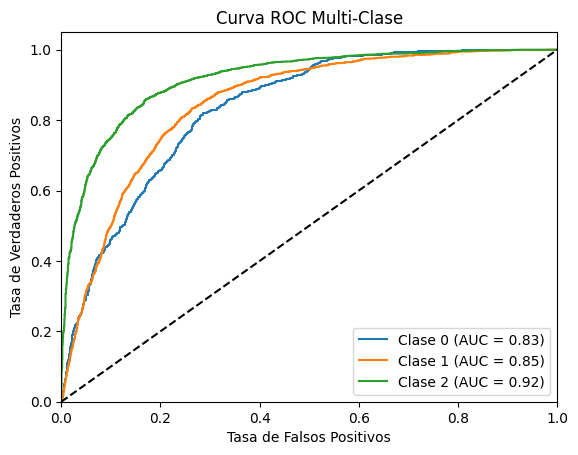

AUC Macro: 0.866
AUC Micro: 0.913


In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# Suponiendo que tienes las probabilidades predichas 'predict_test_lg' y las etiquetas verdaderas 'y_test'
# Binarizar las etiquetas verdaderas para cada clase
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Número de clases
n_classes = y_test_binarized.shape[1]

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predict_test_lg[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC para cada clase
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Clase {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multi-Clase')
plt.legend(loc="lower right")
plt.show()

# Calcular el AUC promedio ponderado (macro) y el AUC ponderado (micro)
roc_auc_macro = roc_auc_score(y_test_binarized, predict_test_lg, average='macro')
roc_auc_micro = roc_auc_score(y_test_binarized, predict_test_lg, average='micro')

print(f"AUC Macro: {roc_auc_macro:.3f}")
print(f"AUC Micro: {roc_auc_micro:.3f}")
